# Python Quickstart for OOI Data
Written by Sage, 8/17/18

The OOI Data Portal provides quick and easy access to most of the datasets collected by the OOI program.  In this tutorial, we will  demonstrate how to programmatically make a request for an OOI dataset and then load and plot the results, all using Python.

First we'll load some required python libraries.

In [62]:
import requests
import os
import re

!pip install netcdf4 
!pip install dask
!pip install xarray
import xarray as xr

import matplotlib.pyplot as plt


## Step 1 - Requesting OOI Data
While you can use the OOI Data Portal to request data, sometimes it is easier to use the [OOI M2M Interface](https://oceanobservatories.org/ooi-m2m-interface/) (aka the OOI API) to request data from specific instruments, especially when you want to script your data processing routine.  In addition, it's also useful when the number of datasets is more than the few it would be okay to do by hand.

In order to use the OOI API, you will first need to create an account on the [OOI Data Portal](https://ooinet.oceanobservatories.org).  Once you have done that, you will need to grab your API username and token, which can be found on your profile page.  We will add them as variables to make it easy to refer to later.

In [0]:
API_USERNAME = 'YOUR USERNAME'
API_TOKEN = 'YOUR TOKEN'

Making asynchronous requests through the API is essentially the same as requesting a download from the OOI Data Portal, but with the API you can easily create one or more requests in an automated way.

To make a data request, we basically construct a URL using the reference designator, delivery method, stream name and other parameters. You can find this information in catalog on the Data Portal.

The URL is constructed using the following format:

`/sensor/inv/{subsite}/{node}/{sensor}/{method}/{stream}`

In order to make the code clear, we're going to setup several variables and concatenate all of the variables together with slashes.

In [0]:
# Instrument Information
site = 'CP04OSSM'
node = 'SBD11'
instrument = '06-METBKA000'
method = 'telemetered'
stream = 'metbk_a_dcl_instrument'

api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'

# Create the request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

Finally, we also need to specify a start (beginDT) and ending date/time (endDT) for our request. By default, asynchronous requests will return NetCDF files, but you could also specify csv or json, using the format option. Optionally, you can also specify include_provenance and include_annotations, which will include separate text files in the output directory with that information.

We will define all of these options in a dictionary object called params.

In [0]:
# All of the following are optional, but you should specify a date range
params = {
  'beginDT':'2016-01-01T00:00:00.000Z',
  'endDT':'2017-01-01T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

Now let's send the request. (Note, you only need to send the request once to generate the data files.  After which, we recommend commenting out the request lines to prevent accidental resubmission when running through the script again.)

In [41]:
# r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
# data = r.json()
# data

{'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html',
  'https://opendap.oceanobservatories.org/async_results/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument'],
 'numberOfSubJobs': 14,
 'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html',
 'requestUUID': '874a1b40-1dfc-4664-8772-aa6b4e0a7989',
 'sizeCalculation': 60326684,
 'timeCalculation': 60}

### Which data URL should I use?
The first URL in the allURLs key points to the THREDDS server, which allows for programmatic data access without downloading the entire file.

In [42]:
print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html


The second URL in the allURLs key provides a direct link to a web server which you can use to quickly download files if you don't want to go through THREDDS.

In [43]:
print(data['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument


## Step 2 - Loading in NetCDF Files
Once the dataset is ready on the server, we can start using it. For this example, it turns out that there are 3 different deployments spanning 2016, and each deployment has its own file.  In order to load in all of the data, we will need to concatenate the data from all of the files.  

The easiest way to do this in Python is to create a list of all of the netcdf files we want to load, and then pass that to `xarray.open_mfdataset()`

First, we will manually specify the THREDDS url we received earlier, so we can rerun this code again later without haveing to re-request the data.

In [0]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'

Next, we can use the following code to automatically find all of the available .nc files in the directory.

In [55]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0005_CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20161012T142641.906000-20161231T235909.571000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0005_CP04OSSM-RID26-04-VELPTA000-telemetered-velpt_ab_dcl_instrument_20161012T143008-20161231T234517.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0004_CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20160527T155046.777000-20161012T150931.977000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-m

When requesting data from some instruments, you will actually get data files from multiple instruments, when they are needed to calculate derived parameters. If this happens, you will need to modify the code above or tweak the resultant list to make sure you only include .nc files from the instrument you are interested in.  In this case, we received both METBK files and VELPT files.  So, let's go through the datasets array and remove the VELPT files which we do not need.

In [56]:
selected_datasets = []
for d in datasets:
    if 'VELPT' in d:
        pass
    else:
        selected_datasets.append(d)
selected_datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0005_CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20161012T142641.906000-20161231T235909.571000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0004_CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20160527T155046.777000-20161012T150931.977000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20180817T170126-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0003_CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20160101T000102.577000-20160513T150947.552000.nc']

Now we can use `xr.open_mfdataset()` to load all files into a single xarray dataset.

In [58]:
ds = xr.open_mfdataset(selected_datasets)
ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
ds = ds.chunk({'time': 100}) # Used for optimization
ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                               (time: 504070)
Coordinates:
    obs                                   (time) int64 0 1 2 3 4 5 6 7 8 9 ...
  * time                                  (time) datetime64[ns] 2016-01-01T00:01:02.576999424 ...
    lat                                   (time) float64 39.94 39.94 39.94 ...
    lon                                   (time) float64 -70.89 -70.89 ...
Data variables:
    deployment                            (time) int32 3 3 3 3 3 3 3 3 3 3 3 ...
    id                                    (time) |S64 b'1f2b2168-867b-404a-9e40-856191f944f7' ...
    air_temperature                       (time) float32 10.297 10.244 ...
    barometric_pressure                   (time) float32 1016.74 1016.67 ...
    dcl_controller_timestamp              (time) object b'empty' b'empty' ...
    driver_timestamp                      (time) datetime64[ns] 2017-10-25T07:12:04.706921984 ...
    eastward_wind_velocity                (time) float32 5.

## Step 3 - Plotting the Results
And now we can plot the results.

In [59]:
# Pull the source attribute to use as a plot title
source = ds.source
source

'CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument'

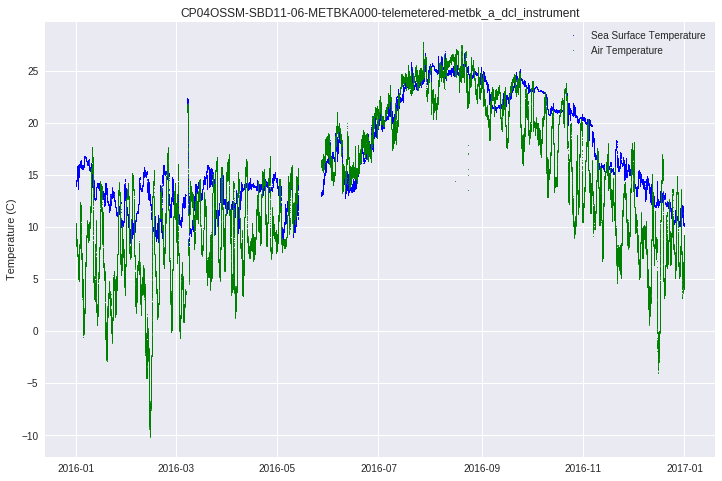

In [81]:
fig, (ax) = plt.subplots(1,1, figsize=(12,8))
plt.plot(ds['time'],ds['sea_surface_temperature'], 'b.', markersize=2, label='Sea Surface Temperature')
plt.plot(ds['time'],ds['air_temperature'], 'g.', markersize=2, label='Air Temperature')
plt.ylabel('Temperature (C)')
plt.title(source)
plt.legend();